In [7]:
# --- import libraries --- #
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

In [8]:
# --- reading csv file --- #
df = pd.read_csv("/content/cinemaTicket_Ref.csv")

In [21]:
sns.set_style('darkgrid')

## Data validation

In [9]:
df.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   film_code     142524 non-null  int64  
 1   cinema_code   142524 non-null  int64  
 2   total_sales   142524 non-null  int64  
 3   tickets_sold  142524 non-null  int64  
 4   tickets_out   142524 non-null  int64  
 5   show_time     142524 non-null  int64  
 6   occu_perc     142399 non-null  float64
 7   ticket_price  142524 non-null  float64
 8   ticket_use    142524 non-null  int64  
 9   capacity      142399 non-null  float64
 10  date          142524 non-null  object 
 11  month         142524 non-null  int64  
 12  quarter       142524 non-null  int64  
 13  day           142524 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 15.2+ MB


In [73]:
df["date"] = pd.to_datetime(df["date"])

In [12]:
df["day_of_week"] = df["date"].dt.dayofweek

In [13]:
def verify_null_counts(data):
  """
  Verify null counts and null percent
  """
  total_rows = len(data)
  null_counts = data.isnull().sum()

  null_percent = (null_counts / total_rows) * 100
  null_data = null_counts[null_counts > 0 ]

  for col in null_data.index :

        print(f"{col} : {null_data[col]} ({null_percent[col]:.2f}%)")

In [14]:
verify_null_counts(df)

occu_perc : 125 (0.09%)
capacity : 125 (0.09%)


In [15]:
df = df.dropna()

## EDA

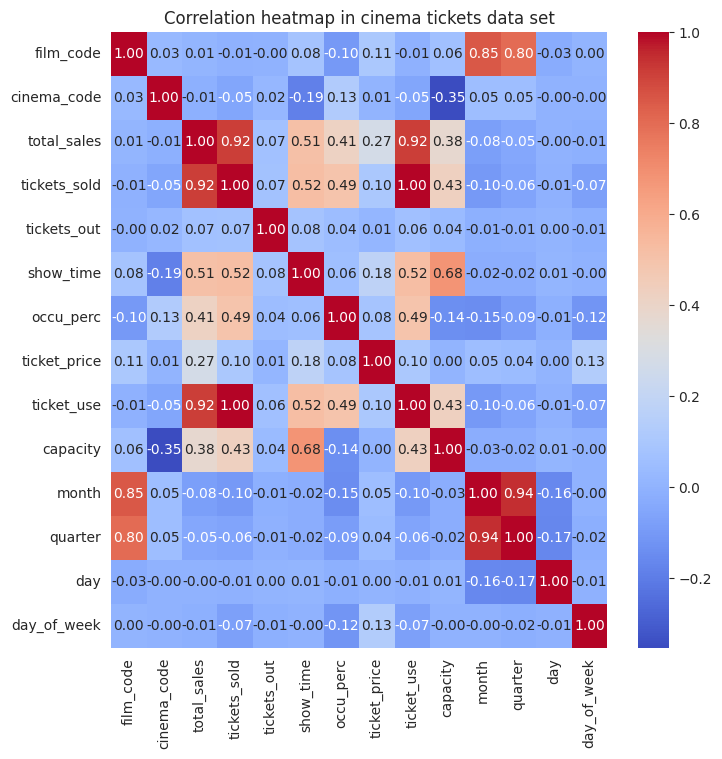

In [22]:
def correlation_mapping(data):
  """
  Correlation heatmap between the columns
  """

  df = data.copy()
  var_numerical = df.select_dtypes(include='number')

  plt.figure(figsize=(8,8))

  corr = var_numerical.corr()

  sns.heatmap(corr,
              annot=True,
              fmt=".2f",
              cmap="coolwarm"
              )
  plt.title("Correlation heatmap in cinema tickets data set")

  plt.show()

correlation_mapping(df)

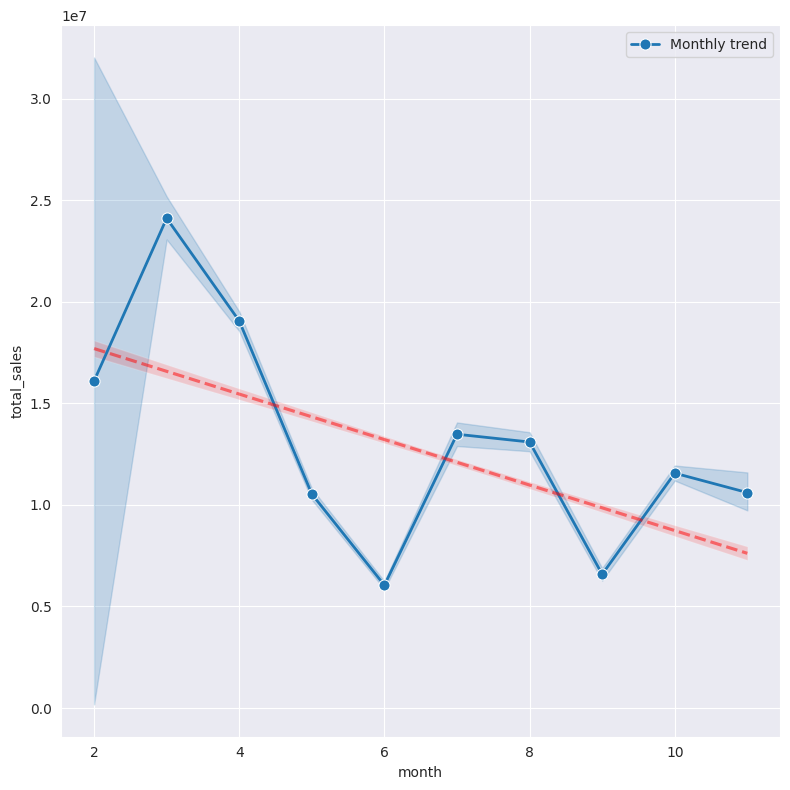

In [107]:
def plot_line_monthly(data,col):
  ''''''

  df = data.copy()
  plt.figure(figsize=(8,8))

  sns.lineplot(data=df,x='month',y=df[col],marker='o',linewidth=2,markersize=8,label='Monthly trend')

  sns.regplot(data=data, y=df[col], x='month', scatter=False,
            line_kws={'color': 'red', 'linestyle': '--', 'alpha': 0.5}, label='Trend')

  plt.tight_layout()
  plt.show()

plot_line_monthly(df,'total_sales')

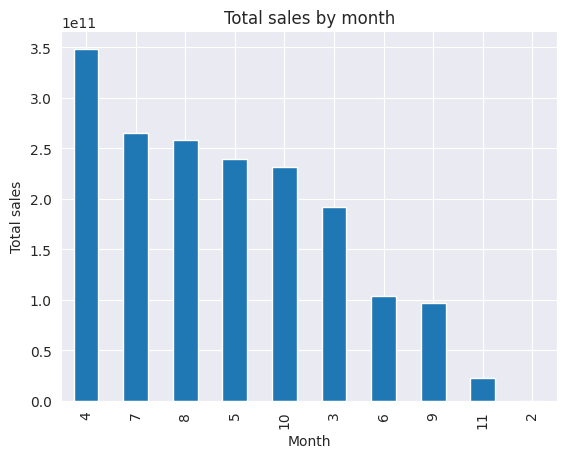

In [23]:
 groupedbysells = df.groupby("month")["total_sales"].sum().sort_values(ascending=False)
groupedbysells.plot(kind="bar")
plt.title("Total sales by month")
plt.xlabel("Month")
plt.ylabel("Total sales")
plt.show()

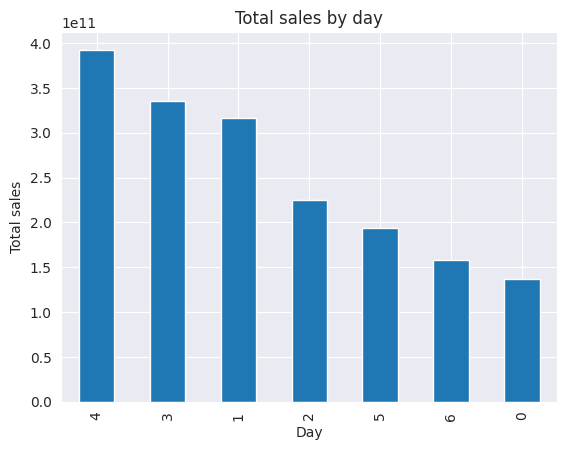

In [24]:
grouby_day = df.groupby("day_of_week")["total_sales"].sum().sort_values(ascending=False)
grouby_day.plot(kind="bar")
plt.title("Total sales by day")
plt.xlabel("Day")
plt.ylabel("Total sales")
plt.show()

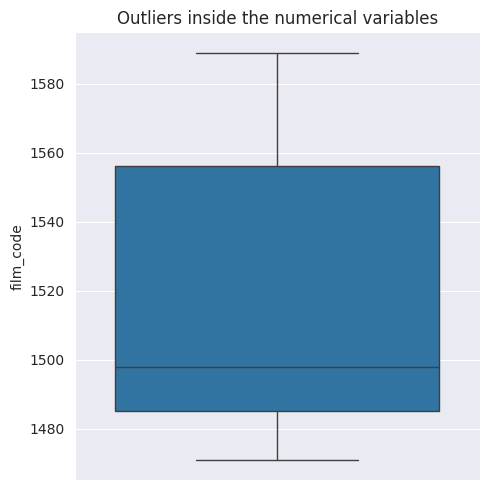

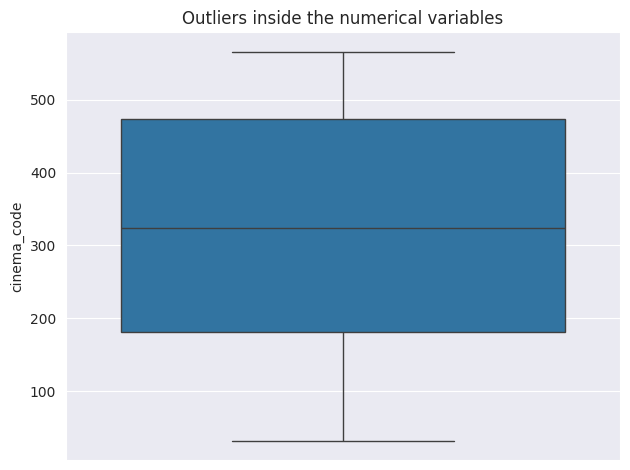

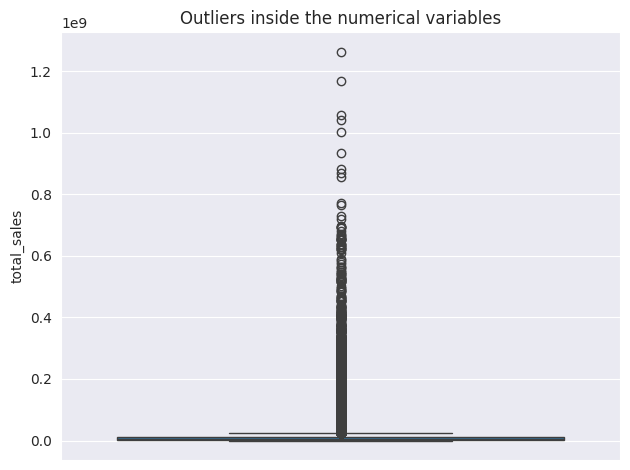

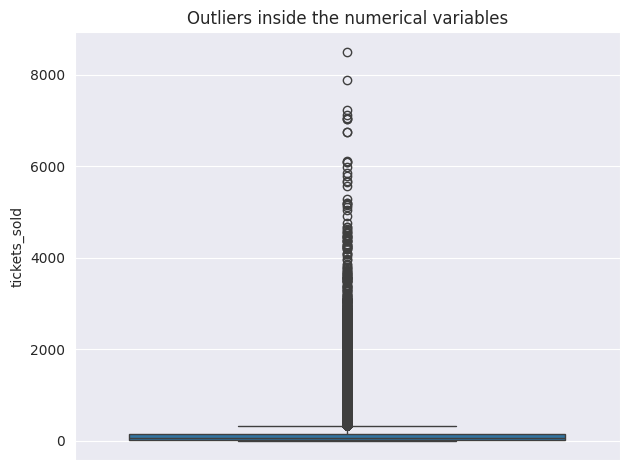

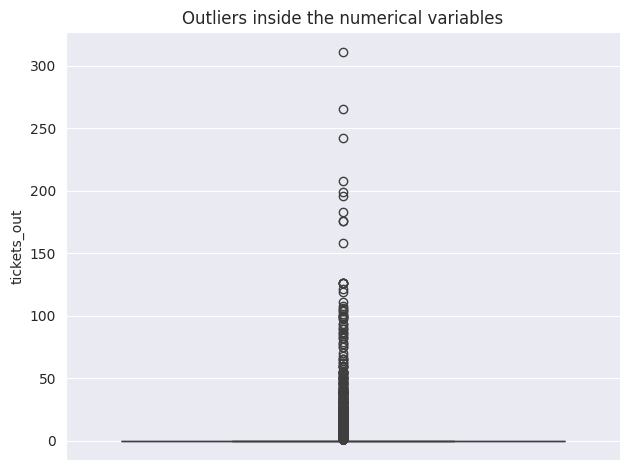

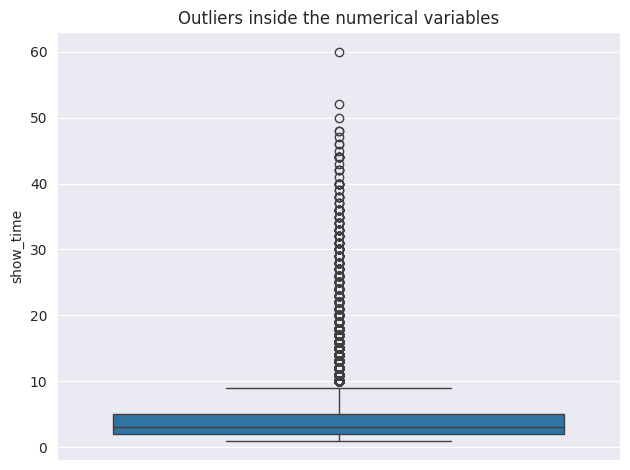

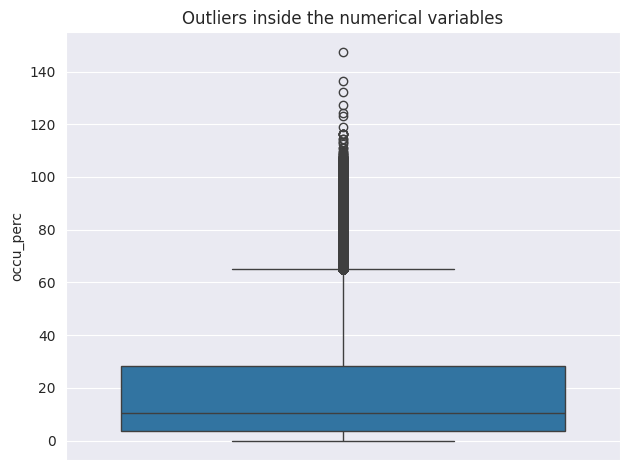

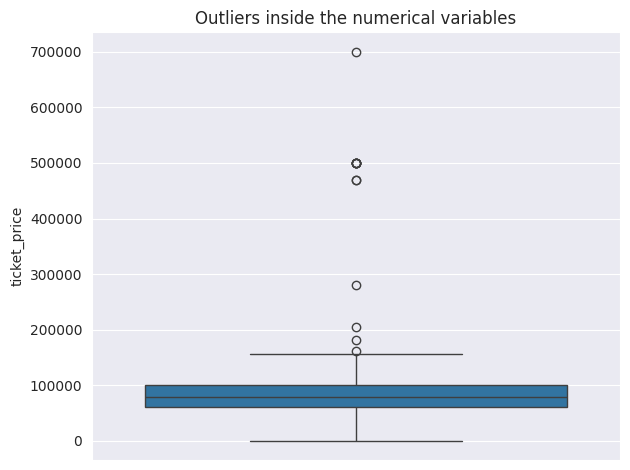

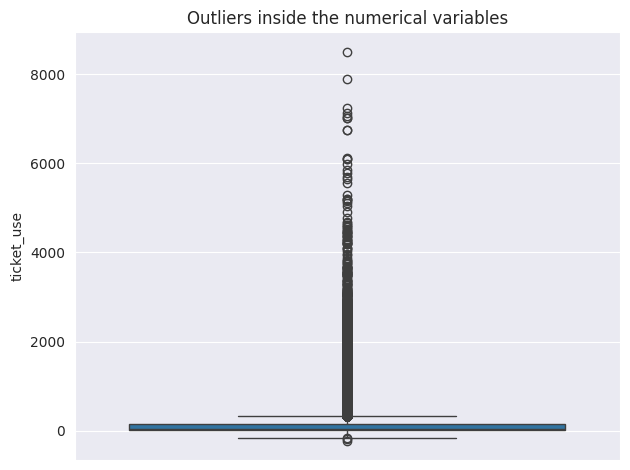

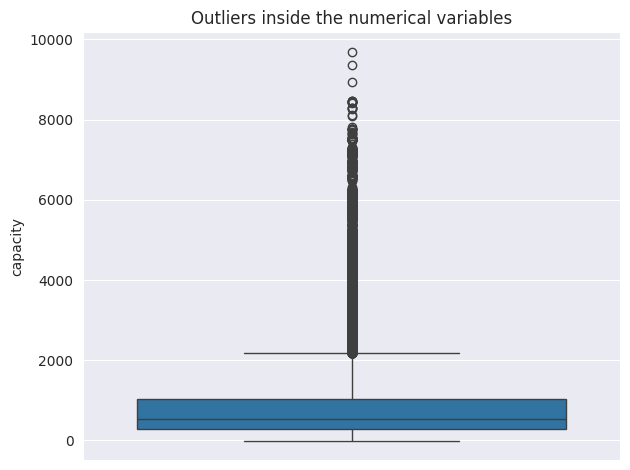

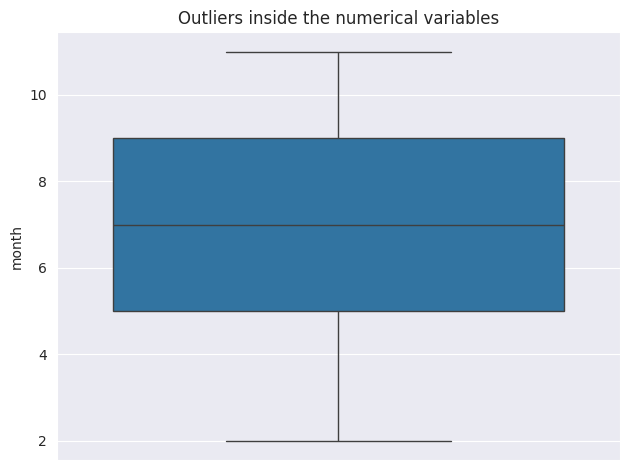

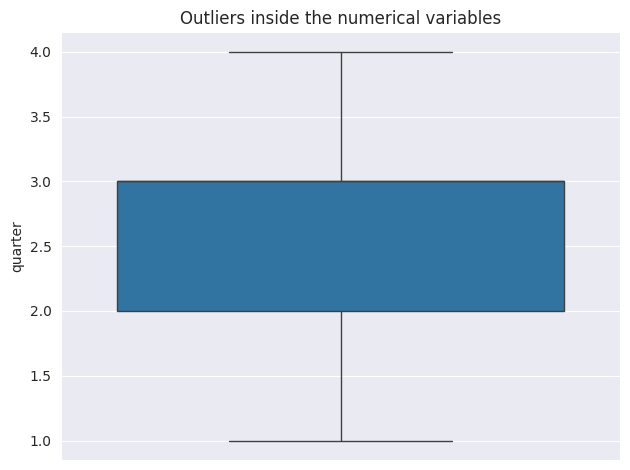

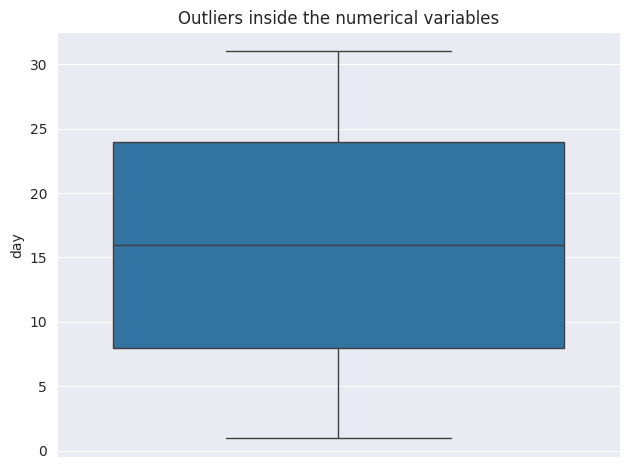

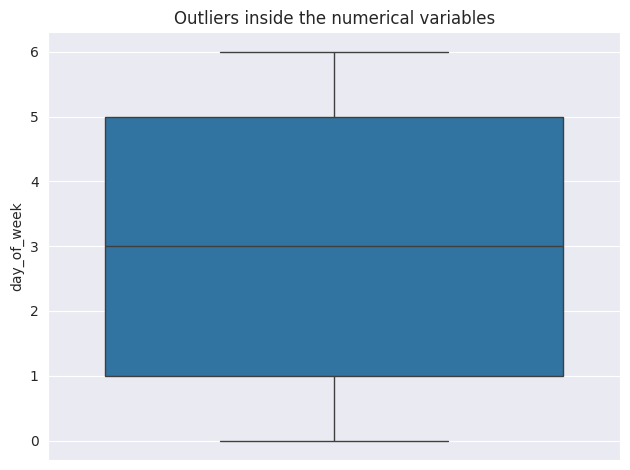

In [57]:
def plot_outliers(data) :
  ''''''

  df = data.copy()
  var_numerical  = df.select_dtypes(include='number').columns # want the columns not the index (thus . columns)

  plt.figure(figsize=(5,5))

  for col in var_numerical :
     sns.boxplot(data=data[col])
     plt.title('Outliers inside the numerical variables')
     plt.xticks(rotation=45)
     plt.tight_layout()
     plt.show()


plot_outliers(df)

In [89]:
def column_outliers_mask(df, col):
    """
    Returns a boolean mask marking outliers in a single numeric column using IQR.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (df[col] < lower) | (df[col] > upper)


In [91]:
def scatter_plot_outliers(df, col):
    """
    Plot a numeric column and highlight its outliers only.
    """
    mask = column_outliers_mask(df, col)
    df_outliers_col = df[mask]

    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=df.index, y=df[col], label='Normal', alpha=0.6)

    if not df_outliers_col.empty:
        sns.scatterplot(x=df_outliers_col.index, y=df_outliers_col[col], color='red', label='Outliers')

    plt.title(f"Outliers Highlighted for '{col}'")
    plt.xlabel("Index")
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Feature engineering

In [44]:
def statistical_features(data):
  df = data.copy()
  stats = {}

  var_numerical = df.select_dtypes(include='number').columns # not index, wanna the columns
  categorical_vars = df.select_dtypes(include=['object','category']).columns

  for col in var_numerical:
    stats[col] = {
        'mean' : df[col].mean(),
        'std' : df[col].std(),
        'median' : df[col].median(),
        'var' : df[col].var()
    }

    stats_df = pd.DataFrame(stats).T # Transpose matrix to be more readable

  return stats_df

df_stats = statistical_features(df)

In [45]:
df_stats.head()

,mean,std,median,var
film_code,1.518989e+03,3.618416e+01,1498.0,1.309294e+03
cinema_code,3.203724e+02,1.596509e+02,324.0,2.548841e+04
total_sales,1.234773e+07,3.063471e+07,3720000.0,9.384857e+14
tickets_sold,1.401771e+02,2.797092e+02,50.0,7.823722e+04
tickets_out,2.373893e-01,2.924231e+00,0.0,8.551126e+00


In [95]:
def outliers_detection_&_remove(data):
  ''''''

  df = data.copy()
  size_df = len(df)

  var_numerical = df.select_dtypes(include='number').columns
  outliers_info = {}

  #init the outliers mask
  outliers_mask = pd.Series(False, index=df.index)

  for col in var_numerical:

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bounder = Q1 - 1.5 * IQR
    upper_bounder = Q3 + 1.5 * IQR

    mask = (df[col] < lower_bounder) | (df[col] > upper_bounder)
    outliers_mask |= mask # mask for the outliers

    outliers_info[col] = {
        'Q1' : Q1,
        'Q3' : Q3,
        'IQR' : IQR,
        'Lower Bounder' : lower_bounder,
        'Upper Bounder' : upper_bounder,
        'Count' : mask.sum(),
        'Outliers percent' : mask.sum()/size_df * 100
        }

    df_outliers_info = pd.DataFrame(outliers_info).T
    df_outliers = df[~outliers_mask]

  return df_outliers_info , df_outliers

df_out_info, df_cleaned = outliers_detection(df)

In [96]:
df_out_info.head()

,Q1,Q3,IQR,Lower Bounder,Upper Bounder,Count,Outliers percent
film_code,1485.0,1556.0,71.0,1378.5,1662.5,0.0,0.000000
cinema_code,181.0,474.0,293.0,-258.5,913.5,0.0,0.000000
total_sales,1280000.0,11120000.0,9840000.0,-13480000.0,25880000.0,16025.0,11.253590
tickets_sold,18.0,143.0,125.0,-169.5,330.5,15006.0,10.537995
tickets_out,0.0,0.0,0.0,0.0,0.0,6121.0,4.298485


In [97]:
df_cleaned.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,timestamp,day_of_week
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5,2018-05-05,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5,2018-05-05,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5,2018-05-05,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5,2018-05-05,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5,2018-05-05,5


## Machine Learning

In [35]:
!pip install catboost lightgbm xgboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
train_size = int(len(df) * 0.8)

def train_spliting(data_2_split):
  pass

In [ ]:
def model_training(model:dict):
  pass